# Self-balancing robot simulation

This notebook contains equations and controller design necessary to stabilize a self-balancing robot, contor it's velocity and position.

The model considered below looks as follows:

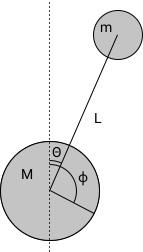

## Free fall model
Let's start with a frictionless model allowing free motion. A mass (m) is attached to a wheel (mass: M, radius: R, moment of inertia $ I = \frac{1}{2} \cdot M \cdot R $) with the rod of length (L).

The governing equations looks as follows:
$$
\begin{cases}
\ddot{\phi} = \frac{mLR\dot{\theta}^2sin(\theta) - mgRsin(\theta)cos(\theta)}{mR^2sin(\theta)^2 + I},\\
\ddot{\theta} = \frac{gsin(\theta) - R\phi^2cos(\theta)}{L}
\end{cases}
$$

Reusing solver from one of the [prevoius notebooks](https://www.kaggle.com/zjor86/ode-solver)

In [2]:
import numpy as np
from numpy import sin, cos, pi

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('seaborn-whitegrid')

/var/folders/65/xk0sjmgs12sgwj29829h0wjw0000gn/T/ipykernel_2715/3564183972.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
def solve(initial_state, times, integrate_func, derivative_func):
    """
    Solves the initial-value problem of the first order ODEs
    :param initial_state: initial state
    :param times: a sequence of time points for which to solve
    :param integrate_func: calculates the next state
    :param derivative_func: computes derivatives of each state component
    :return:
    """
    dt = times[1] - times[0]
    states = [initial_state]
    for step, t in enumerate(times):
        states.append(integrate_func(states[-1], step, t, dt, derivative_func))
    return np.array(states)

def integrate_rk4(state, step, t, dt, dydx_func):
    """
    Fourth-order Runge-Kutta method.
    Source: https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/
    :param step:
    :param state:
    :param t:
    :param dt:
    :param dydx_func:
    :return:
    """
    k1 = dydx_func(state, step, t, dt)
    k2 = dydx_func([v + d * dt / 2 for v, d in zip(state, k1)], step, t, dt)
    k3 = dydx_func([v + d * dt / 2 for v, d in zip(state, k2)], step, t, dt)
    k4 = dydx_func([v + d * dt for v, d in zip(state, k3)], step, t, dt)

    # print ([v + (k1_ + 2 * k2_ + 2 * k3_ + k4_) * dt / 6 for v, k1_, k2_, k3_, k4_ in zip(state, k1, k2, k3, k4)])
    dth, th, dphi, phi = [v + (k1_ + 2 * k2_ + 2 * k3_ + k4_) * dt / 6 for v, k1_, k2_, k3_, k4_ in zip(state, k1, k2, k3, k4)]
    if th > 1.4:
        th = 1.4
        if dth > 0:
            dth = 0
    elif th < -1.4:
        th = -1.4
        if dth < 0:
            dth = 0


    return dth, th, dphi, phi
    # return [v + (k1_ + 2 * k2_ + 2 * k3_ + k4_) * dt / 6 for v, k1_, k2_, k3_, k4_ in zip(state, k1, k2, k3, k4)]

In [4]:
r = 0.25
l = 1.0
M = 0.25
m = 0.3
g = 9.8

I = 0.5 * M * r

def derivate(state, step, t, dt):
    dth, th, dphi, phi = state

    _dphi = (m * l * r * dth ** 2 * sin(th) - m * g * r * sin(th) * cos(th)) / (m * r ** 2 * sin(th) ** 2 + I)
    _dth = (g * sin(th) - r * _dphi * cos(th)) / l

    return [_dth, dth, _dphi, dphi]

In [5]:
times = np.linspace(0, 10, 500)
solution = solve([0.0, pi / 12, .0, .0], times, integrate_rk4, derivate)

def render(solution):
    theta = solution[:, 1]
    phi = solution[:, 3]

    wheel_x = phi * r

    spot_r = 0.7 * r
    wheel_spot_x = wheel_x + spot_r * cos(phi - pi / 2)
    wheel_spot_y = r - spot_r * sin(phi - pi / 2)

    mass_x = wheel_x + l * cos(theta - pi / 2)
    mass_y = r - l * sin(theta - pi / 2)

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-30.5, 30.5), ylim=(-0.5, 1.5))
    ax.set_aspect('equal')
    ax.grid(True)

    line, = ax.plot([], [], 'k-', lw=2)
    wheel = plt.Circle((0.0, r), r, color='black', fill=False, lw=2)
    wheel_spot = plt.Circle((0.0, spot_r), 0.02, color='red')
    mass = plt.Circle((0.0, 0.0), 0.1, color='black')


    def init():
        return []


    def animate(i):
        wheel.set_center((wheel_x[i], r))
        wheel_spot.set_center((wheel_spot_x[i], wheel_spot_y[i]))
        mass.set_center((mass_x[i], mass_y[i]))
        line.set_data([wheel_x[i], mass_x[i]], [r, mass_y[i]])
        patches = [line, ax.add_patch(wheel), ax.add_patch(wheel_spot), ax.add_patch(mass)]
        return patches


    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(solution)),interval=25, blit=True, init_func=init)    
    plt.close(fig)
    return ani

ani = render(solution)

In [6]:
%time ani.save('free_robot.gif', writer='imagemagick', fps=24)

MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

![](./free_robot.gif)

## Adding feedback loop for angle and velocity control

Upright position and the velocity can be controlled with the following feedback loops.

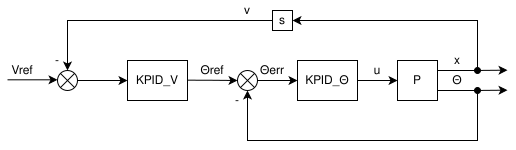


In this setup it finds new balance point if the velocity keeps being different for a long time.

In [6]:
class PIDController:
    def __init__(self, k_p, k_d, k_i, target, init_value=0.0):
        self.Kp = k_p
        self.Kd = k_d
        self.Ki = k_i
        self.target = target
        self.lastValue = init_value
        self.integral_error = 0.0

    def get_control(self, value, dt):
        """
            Returns PID control.
            Derivative spike is mitigated by dError/dt = -dInput/dt
            see: http://brettbeauregard.com/blog/2011/04/improving-the-beginner%e2%80%99s-pid-derivative-kick/
        """
        error = self.target - value

        derivative = -(value - self.lastValue) / dt

        self.lastValue = value
        self.integral_error += error * dt
        return self.Kp * error + self.Kd * derivative + self.Ki * self.integral_error

    def set_target(self, target):
        self.target = target

In [7]:
b1 = 0.01 # Friction coefficient due to rotation of the body
b2 = 0.01 # Friction coefficient due to rotation of the wheel

th_pid = PIDController(k_p=10.0, k_d=2.5, k_i=0.0, target=0.0)
velocity_pid = PIDController(k_p=0.002, k_d=0.001, k_i=0.001, target=0.0)

def limit(v, lim):
    if v > lim:
        return lim
    elif v < -lim:
        return -lim
    else:
        return v

def derivate_velocity_pid(state, step, t, dt):
    dth, th, dphi, phi = state

    th_target = velocity_pid.get_control(dphi, dt)
    th_pid.set_target(th_target)
    u = -th_pid.get_control(th, dt)
    u = limit(u, 10)

    s = sin(th)
    c = cos(th)

    _dphi = (m * r * (l * dth ** 2 * s + b1 * dth * c - g * s * c) - b2 * dphi + u) / (I + m * r ** 2 * s ** 2)
    _dth = (g * s - r * _dphi * c - b1 * dth) / l

    return [_dth, dth, _dphi, dphi]


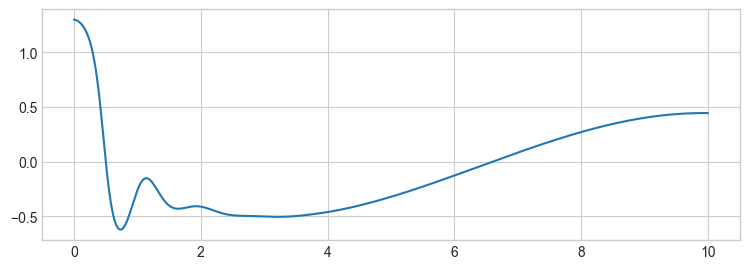

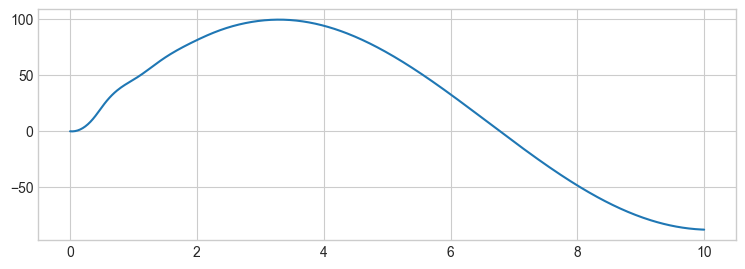

In [8]:
solution = solve([0, 1.3, -10.0, .0], times, integrate_rk4, derivate_velocity_pid)
ani = render(solution)

plt.figure(figsize=(9, 3))
plt.plot(times, solution[1:,1])
plt.figure(figsize=(9, 3))
plt.plot(times, solution[1:,3])

In [9]:
%time ani.save('velocity_pid.gif', writer='imagemagick', fps=24)

MovieWriter imagemagick unavailable; using Pillow instead.


![](./velocity_pid.gif)

## Position control

The diagram below shows how to control robot's position

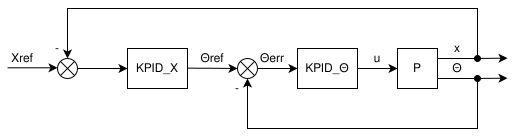

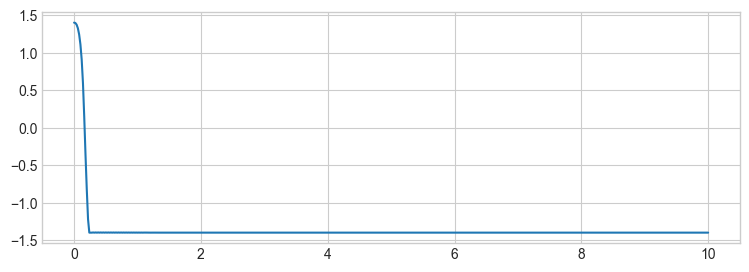

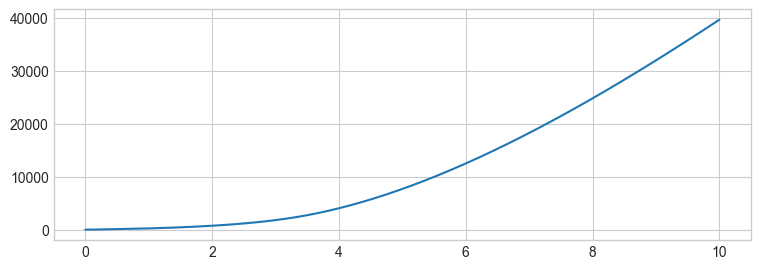

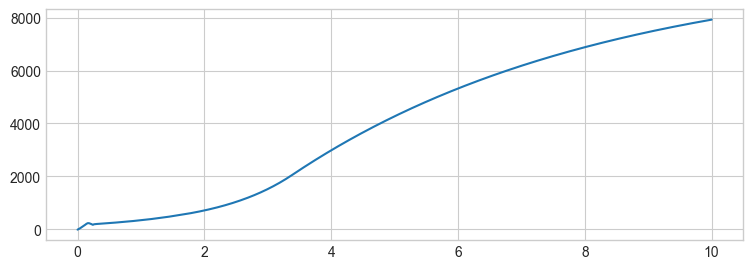

In [24]:
th_pid = PIDController(k_p=40.0, k_d=25.0, k_i=0.0, target=0.0)
position_pid = PIDController(k_p=0.001, k_d=0.07, k_i=0.0001, target=0.0)

def derivate_position_pid(state, step, t, dt):
    dth, th, dphi, phi = state

    th_target = position_pid.get_control(phi, dt)
    th_pid.set_target(th_target)
    u = -th_pid.get_control(th, dt)
    u = limit(u, 100)

    s = sin(th)
    c = cos(th)

    _dphi = (m * r * (l * dth ** 2 * s + b1 * dth * c - g * s * c) - b2 * dphi + u) / (I + m * r ** 2 * s ** 2)
    _dth = (g * s - r * _dphi * c - b1 * dth) / l

    return [_dth, dth, _dphi, dphi]

solution = solve([1, 1.39, -30.0, 10.0], times, integrate_rk4, derivate_position_pid)
ani = render(solution)

plt.figure(figsize=(9, 3))
plt.plot(times, solution[1:,1])
plt.figure(figsize=(9, 3))
plt.plot(times, solution[1:,3])
plt.figure(figsize=(9, 3))
plt.plot(times, solution[1:,2])

In [116]:
%time ani.save('position_pid.gif', writer='imagemagick', fps=24)

MovieWriter imagemagick unavailable; using Pillow instead.


CPU times: user 2min 18s, sys: 1.58 s, total: 2min 19s
Wall time: 2min 21s


![](./position_pid.gif)

Feel free to create your own controller by implementing `derivate_XXX` function

## References
- [Source code of a real robot](https://github.com/zjor/balancing-robot)
- [Project description](https://hackaday.io/project/180126-self-balancing-robot-for-humans)
- [Video of a balancing robot](https://www.youtube.com/watch?v=1LGBiAcChJg)
- [Python code for simulations](https://github.com/zjor/snippets/tree/master/python/ode_solver)